In [52]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import EDA
import regression
import outlier


df = pd.read_csv('ship-data.csv')
train_index = int(df.shape[0] * .8)
df_train = df[:train_index]
df_test = df[train_index:]

# Speed
v = df[df.columns[11]].values
u = df[df.columns[12]].values
x = np.concatenate([v.reshape(-1, 1), u.reshape(-1, 1)], axis=1)
prd = outlier.Rc(x).fit(.002)
df.loc[prd == -1, 'Speed Through Water (knots)'] = df.loc[prd == -1, 'Speed Over Ground (knots)']

# Draft
df.loc[df[df.columns[6]]==0, df.columns[6]] = df.loc[df[df.columns[6]]==0, df.columns[7]]
df.loc[791:796, df.columns[19]] = df.loc[781:790, df.columns[19]].mean()
df.loc[2194:2211, df.columns[19]] = df.loc[2192:2193, df.columns[19]].mean()

# Power
power = ['Time', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)']
df_all = df.drop(power, 1)

df_train = df_all[:train_index]
df_test = df_all[train_index:]

xtr = df_train.drop('Main Engine Fuel Consumption (MT/day)', 1).values
ytr = df_train['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

xte = df_test.drop('Main Engine Fuel Consumption (MT/day)', 1).values
yte = df_test['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

df1 = df_all.drop('Speed Over Ground (knots)', 1)
df1['Trim'] = df1['Draft Forward (meters)'] - df1['Draft Aft (meters)']

pca = PCA(n_components=1, random_state=42)
df1['Draft'] = pca.fit_transform(df.iloc[:, 4:8])

# Wind
wind = ['Weather Service True Wind Speed (knots)', 'Weather Service True Wind Direction (degrees from north)']
df3 = df1.drop(wind, 1)
# df3['Wind'] = df3['Weather Service Apparent Wind Speed (knots)'] * np.cos(df3['Weather Service Apparent Wind Direction (degrees from bow)'])

# Current
df3['Apparent Current Direction'] = df3['Heading (degrees)'] - df3['Weather Service Sea Current Direction (degrees from north)']
df3['Apparent Current Speed'] = df3['Weather Service Sea Current Speed (knots)'] * np.cos(df3['Apparent Current Direction'])
current = ['Weather Service Sea Current Speed (knots)', 'Weather Service Sea Current Direction (degrees from north)']
df4 = df3.drop(current, 1)

df_train = df4[:train_index]
df_test = df4[train_index:]

xtr = df_train.drop('Main Engine Fuel Consumption (MT/day)', 1).values
ytr = df_train['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

xte = df_test.drop('Main Engine Fuel Consumption (MT/day)', 1).values
yte = df_test['Main Engine Fuel Consumption (MT/day)'].values.reshape(-1, 1)

model = regression.Rf(xtr, ytr)
model.fit()

model.model.fit(xtr, ytr)
regression.Test(model.model, xte, yte).score()

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/tianyi/Documents/data_practice/VesselTimeSeries/regression.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(self.xtr, self.ytr)


Train set accuracy:
0.9987387992638139
Test set accuracy:
0.9930295147835023


/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:71: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Accuracy:
0.9796771211486933
RMSE:
2.379739120980619
MAE:
1.5732236091085188


In [53]:
df4['Relation'] = df4.iloc[:, 0]/(df4.iloc[:, 7]+1)

In [16]:
df4.columns

Index(['Main Engine Fuel Consumption (MT/day)', 'Main Engine Using HFO (bool)',
       'Main Engine Using MGO (bool)', 'Draft Forward (meters)',
       'Draft Aft (meters)', 'Draft Mid-1 (meters)', 'Draft Mid-2 (meters)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service Temperature (celsius)', 'Water Depth (meters)', 'Trim',
       'Draft', 'Apparent Current Direction', 'Apparent Current Speed',
       'Relation'],
      dtype='object')

In [54]:
x = df4.drop(['Main Engine Fuel Consumption (MT/day)', 'Speed Through Water (knots)', 'Relation'], 1).values

In [55]:
y = df4.Relation.values.reshape(-1, 1)

In [56]:
model.model.fit(x, y)
regression.Test(model.model, x, y).score()

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


Accuracy:
0.9849958358600052
RMSE:
0.14915504212364608
MAE:
0.043270677426183006


In [57]:
model.feature_importance(df4.drop(['Main Engine Fuel Consumption (MT/day)', 'Speed Through Water (knots)'], 1).columns)

,Feature_Importance
Water Depth (meters),0.198733
Rudder Angle (degrees),0.181925
Weather Service Apparent Wind Speed (knots),0.150375
Draft Aft (meters),0.067802
Trim,0.060206
Draft Mid-2 (meters),0.056619
Weather Service Temperature (celsius),0.048255
Draft,0.046998
Draft Mid-1 (meters),0.046991
Weather Service Apparent Wind Direction (degrees from bow),0.037155


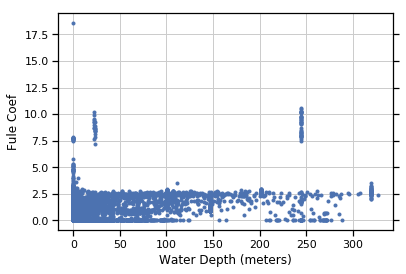

In [75]:
plt.scatter(df4['Water Depth (meters)'], df4['Relation'], marker='.')
plt.xlabel('Water Depth (meters)')
plt.ylabel('Fule Coef')
plt.show()

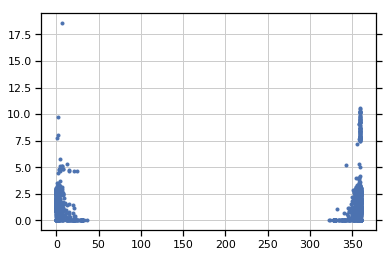

In [59]:
plt.scatter(df4['Rudder Angle (degrees)'], df4['Relation'], marker='.')
plt.show()

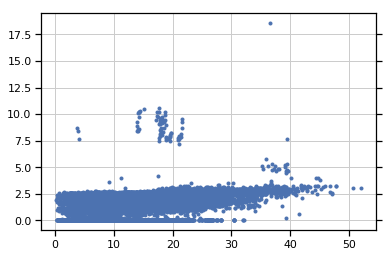

In [60]:
plt.scatter(df4['Weather Service Apparent Wind Speed (knots)'], df4['Relation'], marker='.')
plt.show()

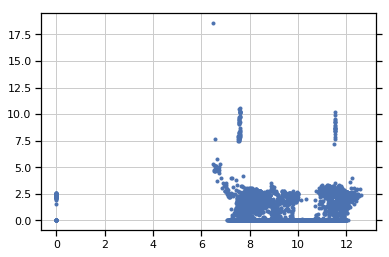

In [61]:
plt.scatter(df4['Draft Aft (meters)'], df4['Relation'], marker='.')
plt.show()

In [62]:
df5 = df4.loc[df4.Relation < 5]

In [63]:
def fun(x):
    if x > 180:
        return x-360
    else:
        return x

In [65]:
df5['Rudder Angle (degrees)'] = df5['Rudder Angle (degrees)'].apply(fun)

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [66]:
x = df5.drop(['Main Engine Fuel Consumption (MT/day)', 'Speed Through Water (knots)', 'Relation'], 1).values
y = df5.Relation.values.reshape(-1, 1)
model.model.fit(x, y)
regression.Test(model.model, x, y).score()

/home/tianyi/anaconda3/envs/insight/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy:
0.9931244976513781
RMSE:
0.09001793618269413
MAE:
0.035107339453057086


In [67]:
model.feature_importance(df4.drop(['Main Engine Fuel Consumption (MT/day)', 'Speed Through Water (knots)'], 1).columns)

,Feature_Importance
Water Depth (meters),0.415015
Draft Mid-2 (meters),0.163653
Rudder Angle (degrees),0.097836
Draft Aft (meters),0.075037
Trim,0.066578
Weather Service Apparent Wind Speed (knots),0.059815
Weather Service Temperature (celsius),0.034157
Heading (degrees),0.018074
Weather Service Apparent Wind Direction (degrees from bow),0.016149
Draft Forward (meters),0.013176


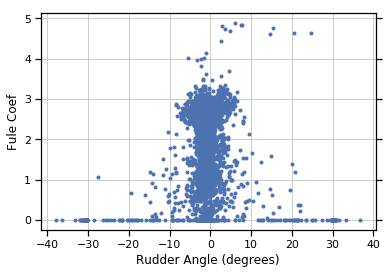

In [77]:
plt.scatter(df5['Rudder Angle (degrees)'], df5['Relation'], marker='.')
plt.xlabel('Rudder Angle (degrees)')
plt.ylabel('Fule Coef')
plt.show()

In [87]:
df6 = df5.loc[(df5['Rudder Angle (degrees)'] > 5) | (df5['Rudder Angle (degrees)'] < -5)]

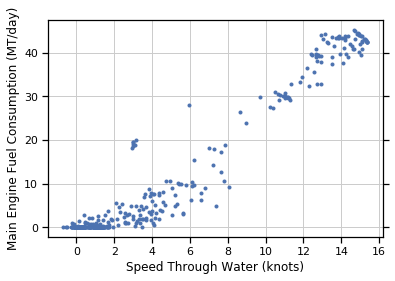

In [88]:
plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.')
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Main Engine Fuel Consumption (MT/day)')
plt.show()

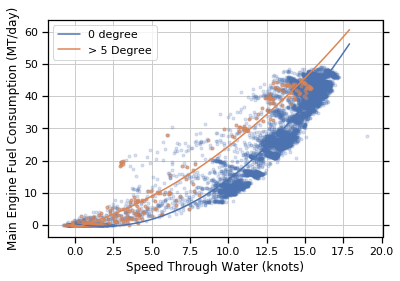

In [116]:
df6 = df5.loc[(df5['Rudder Angle (degrees)'] > -1) | (df5['Rudder Angle (degrees)'] < 1)]
plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.', alpha=.2)
model.fit(df6.iloc[:, 7].values.reshape(-1, 1), df6.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))

df6 = df5.loc[(df5['Rudder Angle (degrees)'] > 5) | (df5['Rudder Angle (degrees)'] < -5)]
model.fit(df6.iloc[:, 7].values.reshape(-1, 1), df6.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))
plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.', alpha=.5)

plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Main Engine Fuel Consumption (MT/day)')
plt.legend(['0 degree', '> 5 Degree'])
plt.show()

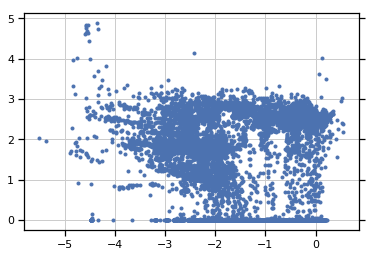

In [73]:
plt.scatter(df5['Trim'], df5['Relation'], marker='.')
plt.show()

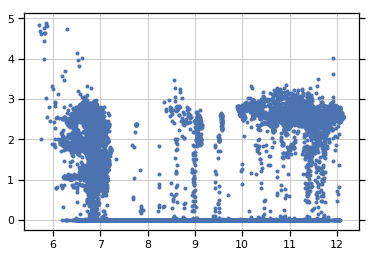

In [117]:
plt.scatter(df5['Draft Mid-2 (meters)'], df5['Relation'], marker='.')
plt.show()

In [150]:
df6.columns

Index(['Main Engine Fuel Consumption (MT/day)', 'Main Engine Using HFO (bool)',
       'Main Engine Using MGO (bool)', 'Draft Forward (meters)',
       'Draft Aft (meters)', 'Draft Mid-1 (meters)', 'Draft Mid-2 (meters)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service Temperature (celsius)', 'Water Depth (meters)', 'Trim',
       'Draft', 'Apparent Current Direction', 'Apparent Current Speed',
       'Relation'],
      dtype='object')

In [157]:
df6 = df5.loc[((df5['Rudder Angle (degrees)'] > -1) | (df5['Rudder Angle (degrees)'] < 1))]

In [158]:
df6 = df6.loc[(df6['Weather Service Apparent Wind Speed (knots)'] > 0) & (df6['Weather Service Apparent Wind Speed (knots)'] < 20)]


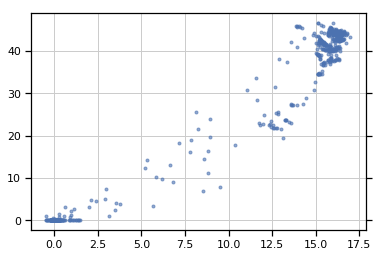

In [159]:
df7 = df6.loc[(df6['Draft Mid-2 (meters)'] > 10) & (df6['Draft Mid-2 (meters)'] < 11)]
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=.6)
plt.show()

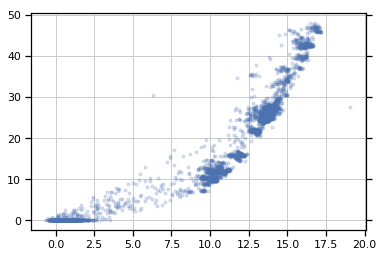

In [160]:
df7 = df6.loc[(df6['Draft Mid-2 (meters)'] > 6) & (df6['Draft Mid-2 (meters)'] < 7)]
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=.2)
plt.show()

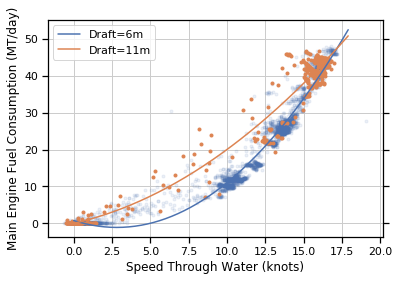

In [167]:
df7 = df6.loc[(df6['Draft Mid-2 (meters)'] > 6) & (df6['Draft Mid-2 (meters)'] < 7)]
model.fit(df7.iloc[:, 7].values.reshape(-1, 1), df7.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=.1)


df7 = df6.loc[(df6['Draft Mid-2 (meters)'] > 10) & (df6['Draft Mid-2 (meters)'] < 11)]
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=1)
model.fit(df7.iloc[:, 7].values.reshape(-1, 1), df7.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Main Engine Fuel Consumption (MT/day)')
plt.legend(['Draft=6m', 'Draft=11m'])
plt.show()

In [ ]:
df6 = df5.loc[(df5['Rudder Angle (degrees)'] > -1) | (df5['Rudder Angle (degrees)'] < 1)]
plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.', alpha=.2)
model.fit(df6.iloc[:, 7].values.reshape(-1, 1), df6.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))

df6 = df5.loc[(df5['Rudder Angle (degrees)'] > 5) | (df5['Rudder Angle (degrees)'] < -5)]
model.fit(df6.iloc[:, 7].values.reshape(-1, 1), df6.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))
plt.scatter(df6.iloc[:, 7], df6.iloc[:, 0], marker='.', alpha=.5)

plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Main Engine Fuel Consumption (MT/day)')
plt.legend(['0 degree', '> 5 Degree'])
plt.show()

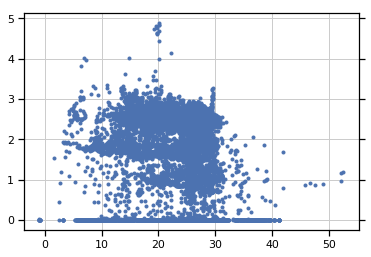

In [181]:
plt.scatter(df5['Weather Service Temperature (celsius)'], df5['Relation'], marker='.')
plt.show()

In [168]:
df6 = df5.loc[((df5['Rudder Angle (degrees)'] > -1) | (df5['Rudder Angle (degrees)'] < 1))]
df6 = df6.loc[(df6['Draft Mid-2 (meters)'] > 6) & (df6['Draft Mid-2 (meters)'] < 7)]

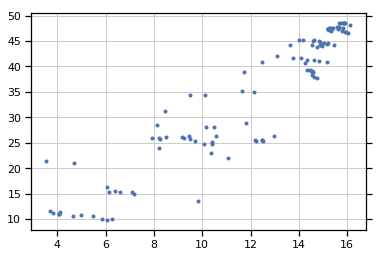

In [173]:
df7 = df6.loc[(df6['Weather Service Apparent Wind Speed (knots)'] > 33) & (df6['Weather Service Apparent Wind Speed (knots)'] < 40)]
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=1)
plt.show()

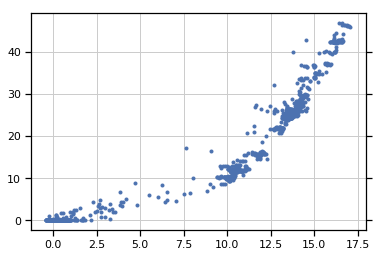

In [171]:
df7 = df6.loc[(df6['Weather Service Apparent Wind Speed (knots)'] > 8) & (df6['Weather Service Apparent Wind Speed (knots)'] < 12)]
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=1)
plt.show()

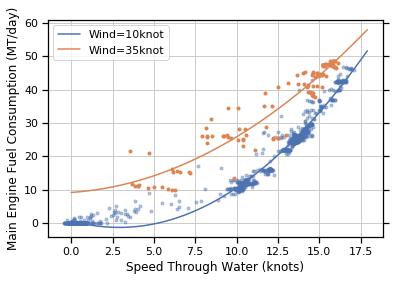

In [177]:
df7 = df6.loc[(df6['Weather Service Apparent Wind Speed (knots)'] > 8) & (df6['Weather Service Apparent Wind Speed (knots)'] < 12)]
model.fit(df7.iloc[:, 7].values.reshape(-1, 1), df7.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=.4)


df7 = df6.loc[(df6['Weather Service Apparent Wind Speed (knots)'] > 33) & (df6['Weather Service Apparent Wind Speed (knots)'] < 40)]
plt.scatter(df7.iloc[:, 7], df7.iloc[:, 0], marker='.', alpha=1)
model.fit(df7.iloc[:, 7].values.reshape(-1, 1), df7.iloc[:, 0].values.reshape(-1, 1))
plt.plot(np.arange(0,18, .1), model.predict(np.arange(0,18, .1).reshape(-1, 1)))
plt.xlabel('Speed Through Water (knots)')
plt.ylabel('Main Engine Fuel Consumption (MT/day)')
plt.legend(['Wind=10knot', 'Wind=35knot'])
plt.show()

In [188]:
df4['Speed Over Ground (knots)'] = df['Speed Over Ground (knots)']

In [186]:
df.columns

Index(['Time', 'Main Engine Fuel Consumption (MT/day)',
       'Main Engine Using HFO (bool)', 'Main Engine Using MGO (bool)',
       'Draft Forward (meters)', 'Draft Aft (meters)', 'Draft Mid-1 (meters)',
       'Draft Mid-2 (meters)', 'Shaft Speed (RPM)', 'Shaft Torque (kNm)',
       'Shaft Power (kW)', 'Speed Over Ground (knots)',
       'Speed Through Water (knots)', 'Heading (degrees)',
       'Rudder Angle (degrees)', 'Weather Service Apparent Wind Speed (knots)',
       'Weather Service Apparent Wind Direction (degrees from bow)',
       'Weather Service True Wind Speed (knots)',
       'Weather Service True Wind Direction (degrees from north)',
       'Weather Service Temperature (celsius)',
       'Weather Service Sea Current Direction (degrees from north)',
       'Weather Service Sea Current Speed (knots)', 'Water Depth (meters)'],
      dtype='object')